# Imports and configs 
* If you're running this locally, replace my OpenAI key with yours 

In [1]:
import networkx as nx
import numpy as np 
from openai import OpenAI
import io
import matplotlib.pyplot as plt 
import base64
import requests
from typing import List

import warnings
warnings.filterwarnings("ignore")

# Replace with your own OpenAI api key 
client = OpenAI(api_key=open("/Users/mosobay/Dropbox (MIT)/research/openai_api", "r").read().strip())
api_key = open("/Users/mosobay/Dropbox (MIT)/research/openai_api", "r").read().strip()
headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

# Helper functions 
* Figure out multiple graph comparisons for the text pipeline -- doesn't work smoothly. 

In [22]:
def get_graph_base64(nx_graph):
    graphviz_io = io.BytesIO()
    plt.figure()
    nx.draw_networkx(nx_graph)
    plt.savefig(graphviz_io, format="jpg")
    graphviz_io.seek(0)
    graphviz_base64data = base64.b64encode(graphviz_io.read()).decode()
    
    return graphviz_base64data

def get_graph_base64_voting(nx_graph, node_votes):
    graphviz_io = io.BytesIO()
    plt.figure()
    nx.draw_networkx(nx_graph, node_color=node_votes, font_color="white")
    plt.savefig(graphviz_io, format="jpg")
    graphviz_io.seek(0)
    graphviz_base64data = base64.b64encode(graphviz_io.read()).decode()
    
    return graphviz_base64data


def query_gpt4vision(query_string: str, list_networks: List[nx.classes.graph.Graph]):
    list_graph_base64 = [get_graph_base64(x) for x in list_networks]
    payload_content = [{"type": "text", "text": query_string}]
    
    for graph in list_graph_base64:
        payload_content.append({"type": "image_url",
                                "image_url": {"url": f"data:image/jpeg;base64,{graph}"}})
    
    
    payload = {
        "model": "gpt-4-vision-preview",
        "messages": [{"role": "user",
                      "content": payload_content}],
        "max_tokens": 1000}
    
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    response_str = response.json()["choices"][0]["message"]["content"]
    
    return response_str, response


def query_gpt4text(query_string: str, network: nx.classes.graph.Graph):
    
    system_prompt = f"""You will be asked to answer questions about the following adjacency matrix. An adjacency matrix describes how nodes in a social network are connected, where agents are indexed by number (the first row describes how Agent 0 is connected to other agents, and so forth). The adjacency matrix is:\n{np.array2string(nx.adjacency_matrix(network).todense())}"""    
    nx.draw_networkx(network)
    response = client.chat.completions.create(
      model="gpt-4-1106-preview", max_tokens=1000,
      messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": query_string}
      ]
    )
    
    response_str = response.choices[0].message.content
    
    return response_str, response


def query_gpt4vision_voting(query_string: str, 
                     list_networks: List[nx.classes.graph.Graph],
                     list_votes: List[List[str]]):
    
    list_graph_base64 = [get_graph_base64_voting(list_networks[x], list_votes[x]) for x in range(len(list_networks))]
    payload_content = [{"type": "text", "text": query_string}]
    
    for graph in list_graph_base64:
        payload_content.append({"type": "image_url",
                                "image_url": {"url": f"data:image/jpeg;base64,{graph}"}})
    
    
    payload = {
        "model": "gpt-4-vision-preview",
        "messages": [{"role": "user",
                      "content": payload_content}],
        "max_tokens": 1000}
    
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    response_str = response.json()["choices"][0]["message"]["content"]
    
    return response_str, response



def query_gpt4text_voting(query_string: str, network: nx.classes.graph.Graph, list_votes: List[str]):
    
    system_prompt = f"""You will be asked to answer questions about the following adjacency matrix. An adjacency matrix describes how nodes in a social network are connected, where agents are indexed by number (the first row describes how Agent 0 is connected to other agents, and so forth). The adjacency matrix is:\n{np.array2string(nx.adjacency_matrix(network).todense())}"""    
    system_prompt_votes = f"""Each agent in the node has chosen either 'red' or 'blue', as given in the follow JSON:\n{str(dict(zip(['Agent {}'.format(x) for x in range(len(network.nodes))],list_votes)))}"""
    
    nx.draw_networkx(network, node_color=list_votes, font_color="white")
    response = client.chat.completions.create(
      model="gpt-4-1106-preview", max_tokens=1000,
      messages=[
        {"role": "system", "content": system_prompt},
        {"role": "system", "content": system_prompt_votes},
        {"role": "user", "content": query_string}
      ]
    )
    
    response_str = response.choices[0].message.content
    
    return response_str, response

# Basic functionality examples
* Given a network defined using NetworkX, the text pipeline `query_gpt4text` will present the network to the LLM as an adjacency matrix, while the visual pipeline `query_gpt4vision` will present the network to the LLM as an image. 
* For both pipelines, a network graph is displayed, so the user can make sense of the LLM response 

## Simple star graph with vision pipeline 

This image represents a simple graph consisting of six nodes (or vertices) labeled 0 to 5, connected by lines which are called edges. The graph depicts a star network topology where node 0 appears to be the central node, and it is directly connected to all other nodes (1, 2, 3, 4, and 5) without any of these other nodes being connected to each other.

Such a graph can be used to represent a social network where node 0 could be an individual who has direct relationships with all other individuals represented by the other nodes. However, there are no direct relationships between the other individuals, as indicated by the lack of edges connecting nodes 1-5 directly to each other. This could be indicative of a social structure where one central figure maintains separate individual relationships with various others who do not interact among themselves within the context of this network.


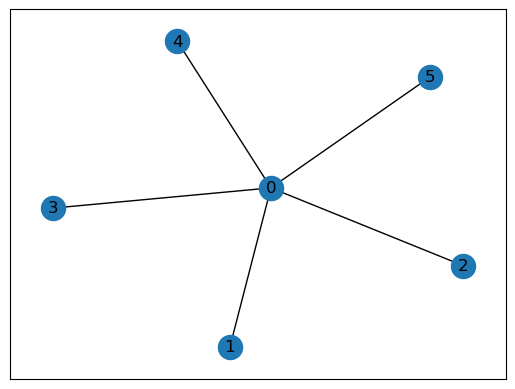

In [4]:
print(query_gpt4vision("Describe the social network in this graph",
                            [nx.star_graph(5)])[0])

## Simple star graph with text pipeline 

The social network described by the given adjacency matrix has six agents labeled as 0, 1, 2, 3, 4, and 5. In an adjacency matrix, the rows and columns correspond to the nodes (agents) in the network. The entry in row i and column j is 1 if there is a connection (edge) between the nodes i and j, and 0 if there is no connection.

According to the given adjacency matrix:

- Agent 0 is connected to all other agents (1, 2, 3, 4, and 5); this is shown in the first row, with ones in all positions except the first, which is zero as there is no self-connection.
- Agents 1, 2, 3, 4, and 5 are connected only to Agent 0 and not to any other agents. This is depicted in the matrix with ones in the first column but zeroes in all other positions in rows 1, 2, 3, 4, and 5.

The social network, therefore, forms a star topology with Agent 0 at the center connected to all other agents on the periphery who in turn are not connected to each other. Agent 0 acts as a central hub or connector for all communic

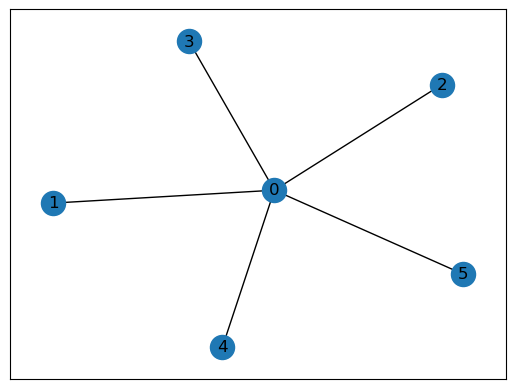

In [5]:
print(query_gpt4text("Describe the social network in this graph",
                            nx.star_graph(5))[0])

## Comparing two networks with the vision pipeline

I'm sorry, but you didn't provide an image with your request. If you have specific images you'd like to compare, please upload them, and I'll be happy to help analyze their content. If you're referring to graphs or diagrams of social networks, please provide a description or data, and I can help you compare them.


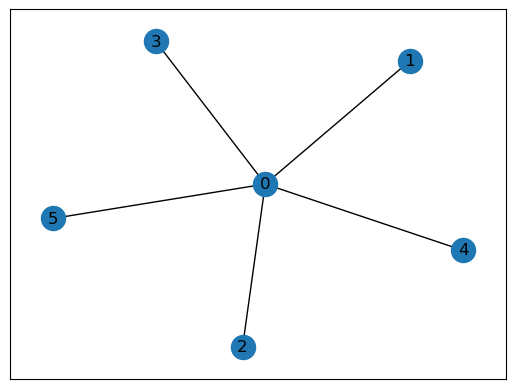

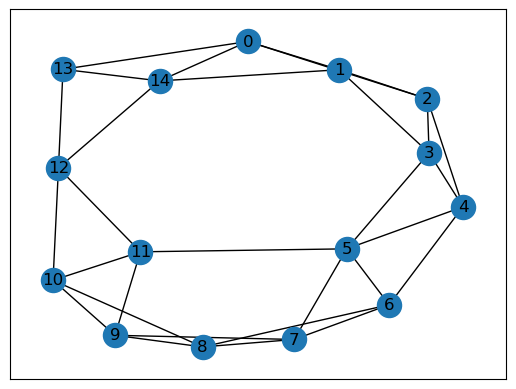

In [7]:
print(query_gpt4vision("Compare the two social networks presented in these graphs",
                            [nx.star_graph(5), nx.watts_strogatz_graph(15,4,0.1,seed=2024)])[0])

# Describing global and node-level properties 

## Node-level properties (e.g. degree)

The degree of a node in a graph is the number of edges connected to that node. Looking at the graph, we can determine the degree of each node:

- Node 0: Degree 5 (since there are five edges coming out of this node)
- Node 1: Degree 1
- Node 2: Degree 1
- Node 3: Degree 1
- Node 4: Degree 1
- Node 5: Degree 1

Node 0 has the highest degree centrality, because it has the most connections to other nodes in the graph. Degree centrality is a measure of the number of connections a node has to other nodes within the network, and a higher degree means higher centrality. In this case, node 0 is the central node of the graph.


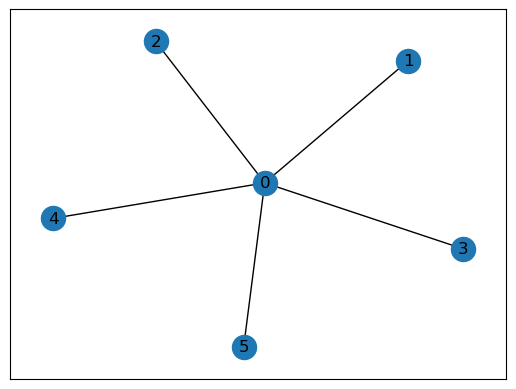

In [8]:
# Vision
print(query_gpt4vision("What is the degree of each node in this graph? Which node has the highest degree centrality?",
                            [nx.star_graph(5)])[0])

The degree of a node in a graph is the number of connections it has to other nodes. The adjacency matrix you provided represents a directed graph with six nodes (0 through 5), where the entry at row i and column j indicates the presence of a directed edge from node i to node j if the entry is 1 and no edge if the entry is 0.

Let's count the degree for each node:

Node 0: This node has a directed edge to all other nodes (nodes 1-5), so its out-degree is 5 (number of outgoing edges). However, it also has incoming edges from nodes 1 to 5, so its in-degree is also 5. So in total, we can consider its degree to be 10 (combined in-degree and out-degree).

Node 1: This node has an edge going to node 0 and no other edges, so it has an out-degree of 1 and an in-degree of 0. Its total degree is therefore 1.

Node 2: Similar to node 1, node 2 has an out-degree of 1 and an in-degree of 0. Its total degree is also 1.

Node 3: This node follows the same pattern as nodes 1 and 2, with an out-degree o

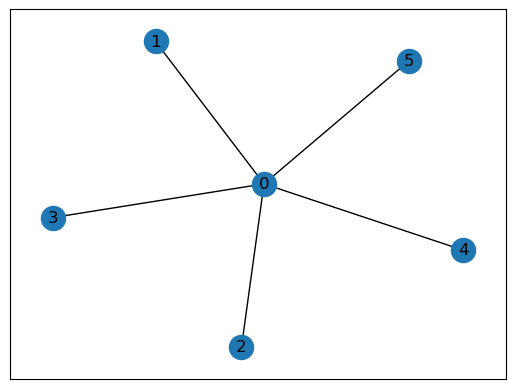

In [9]:
# Text (with betweenness centrality, which the LLM typically will not do without code interpreter)
print(query_gpt4text("What is the degree of each node in this graph? Which node has the highest betweenness centrality?",
                            nx.star_graph(5))[0])

## Analysis of a more complex network 
* Here, we use the text-based representation, as overlaps in the rendering of the graph can mess things up 

The degree of each node can be calculated by summing the values in each row of the adjacency matrix, as every 1 in a node's row corresponds to an edge connecting it to another node.

Here are the degrees:

- Agent 0: sum(0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1) = 4
- Agent 1: sum(1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1) = 4
- Agent 2: sum(1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) = 4
- Agent 3: sum(0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0) = 4
- Agent 4: sum(0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0) = 4
- Agent 5: sum(0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0) = 5
- Agent 6: sum(0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0) = 4
- Agent 7: sum(0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0) = 4
- Agent 8: sum(0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0) = 4
- Agent 9: sum(0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0) = 4
- Agent 10: sum(0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0) = 4
- Agent 11: sum(0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0) = 4
- Agent 12: sum(0, 0, 0,

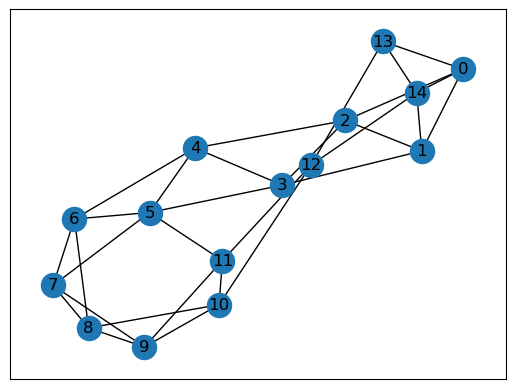

In [10]:
print(query_gpt4text("What is the degree of each node in this graph? Which node has the highest betweenness centrality?",
                            nx.watts_strogatz_graph(15,4,0.1,seed=2024))[0])

## Identifying and comparing network structures 

The graph depicts a star network topology. This type of network has a central node (in this case, node 0) that is directly connected to all other nodes in the network (nodes 1, 2, 3, 4, and 5). The central node acts as a hub through which all traffic flows. This topology is commonly used in small networks or as part of a larger network's sub-structure. It is characterized by its simplicity and ease of understanding, but the entire network is dependent on the functioning of the central hub. If the central node fails, the other nodes will not be able to communicate with each other.


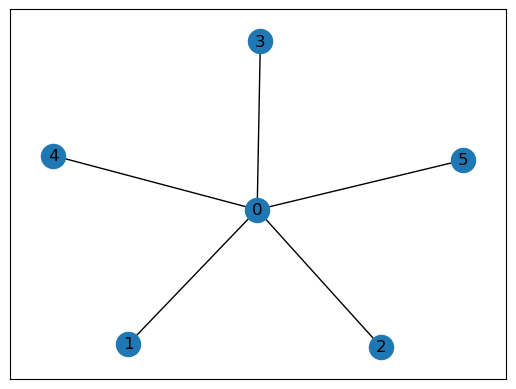

In [11]:
# Vision 
print(query_gpt4vision("What is the structure of the network described in this graph?",
                            [nx.star_graph(5)])[0])

The structure of the network described by the given adjacency matrix is a star topology. In this structure, one central node (Agent 0) is connected to all other nodes, while those nodes are not connected to each other.

Here's a breakdown of the connections:

- Agent 0 is connected to Agents 1, 2, 3, 4, and 5.
- Agent 1 is connected to Agent 0 only.
- Agent 2 is connected to Agent 0 only.
- Agent 3 is connected to Agent 0 only.
- Agent 4 is connected to Agent 0 only.
- Agent 5 is connected to Agent 0 only.

All other pairs of agents are not directly connected to each other. This means Agent 0 is a central hub or node, and all other nodes (Agents 1-5) are at the periphery, connected only to this central node. The star network is commonly used in computer networks where a central server connects with various clients, but the clients do not directly communicate with each other.


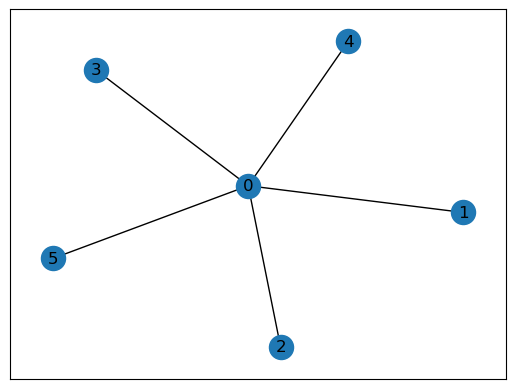

In [12]:
# Text 
print(query_gpt4text("What is the structure of the network described in this graph?",
                            nx.star_graph(5))[0])

## Comparing global structure of two networks 

The Watts-Strogatz model for small-world networks is characterized by a high clustering coefficient and a short average path length. It is typically constructed by starting with a regular lattice or ring, where each node is connected to its nearest neighbors, and then randomly rewiring some fraction of the edges to create shortcuts across the network.

In the two networks provided, the second network with nodes labeled from 0 to 14 organized in a ring structure, with each node connected to its nearest neighbors and additional links that create shortcuts between distant nodes, shows properties of a Watts-Strogatz small world network. The reason is that it starts as a regular ring lattice where each node appears to be connected to its nearest neighbors, and then it appears some edges have been rewired to create the "small-world" effect. This rewiring shortens the average path length and increases the accessibility of the network, while maintaining higher clustering than would be expected

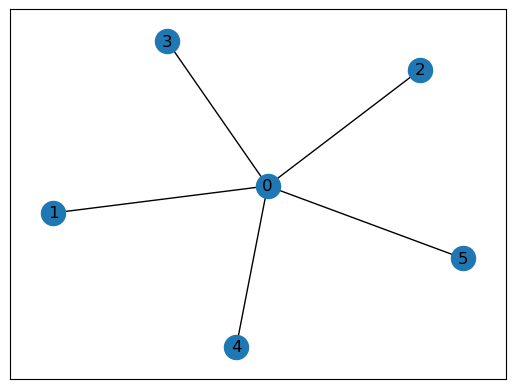

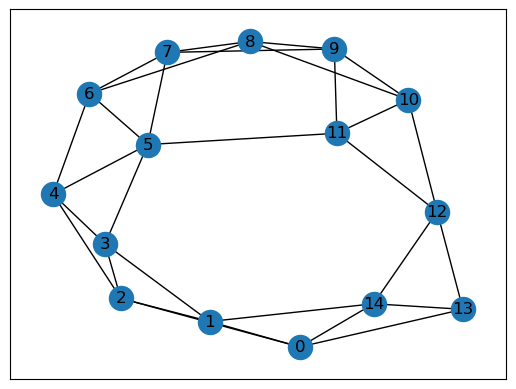

In [13]:
print(query_gpt4vision("Which of these two networks shows properties of a Watts-Strogatz small world network?",
                            [nx.star_graph(5),
                             nx.watts_strogatz_graph(15,4,0.1,seed=2024)])[0])

# Describing influence in networks (and extending to different domains)

## Negative case of a cycle graph, in which no node is more influential than the other. 

In the context of a social network, influence can be measured in several ways. One common way to assess the influence of a node in a network is to use degree centrality, which is calculated by the number of connections (edges) a node has. In an adjacency matrix, the number of connections that a node has can be counted by summing the values in its row (or column, since the matrix is symmetric in the case of an undirected network).

Here's the sum of connections for each node in the given adjacency matrix:

- Agent 0: 2 (connected to Agents 1 and 6)
- Agent 1: 2 (connected to Agents 0 and 2)
- Agent 2: 2 (connected to Agents 1 and 3)
- Agent 3: 2 (connected to Agents 2 and 4)
- Agent 4: 2 (connected to Agents 3 and 5)
- Agent 5: 2 (connected to Agents 4 and 6)
- Agent 6: 2 (connected to Agents 0 and 5)

Since every node has two connections, they all have the same degree centrality. Therefore, based on this metric, no single node is more influential than the others; they all have the same

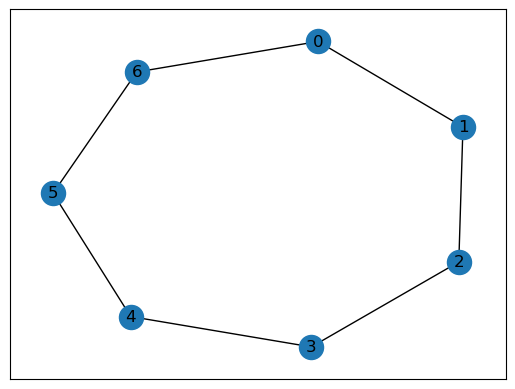

In [14]:
print(query_gpt4text("Which node is most influential in this social network of people?",
                            nx.cycle_graph(7))[0])

## A positive case of a star graph, where one node is most influential as measured by degree centrality (text pipeline) 

In the given adjacency matrix, we can determine the most influential node by looking at the number of connections it has with other nodes. This can also be thought of in terms of degree centrality in the context of network analysis where the central node has the maximum degree (number of connections).

Analyzing the matrix:
```
[[0 1 1 1 1 1]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]
```
We can count how many connections each node (agent) has:
- Agent 0 is connected to Agents 1, 2, 3, 4, and 5 (5 connections).
- Agents 1, 2, 3, 4, and 5 each are connected only to Agent 0 (1 connection each).

Agent 0 has the highest number of connections, indicating that Agent 0 is the most influential in this social network.


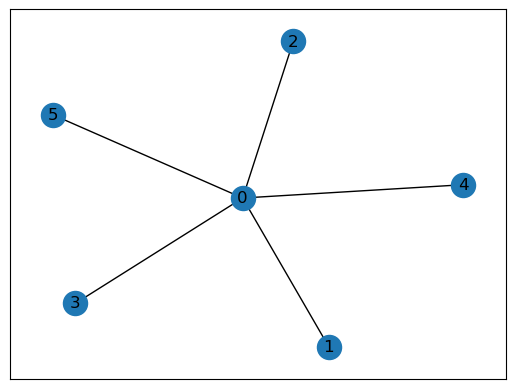

In [15]:
print(query_gpt4text("Which node is most influential in this social network of people?",
                            nx.star_graph(5))[0])

## Framing the query as identifying an information broker 

An information broker in a social network is a node (or agent) that can control and influence the flow of information because of its strategic position within the network. Usually, this would be a node that has many connections or bridges critical gaps between different parts of a network.

Looking at the given adjacency matrix:

```
[[0, 1, 1, 1, 1, 1],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0]]
```

This represents a network where Agent 0 is connected to Agents 1 through 5, and these agents are not connected to each other – they only connect through Agent 0. Agents 1 through 5 have a degree of 1, meaning they are only connected to one other node, which is Agent 0. Agent 0 has a degree of 5, meaning it is connected to all other nodes in the network.

Given this structure, Agent 0 is the most useful as an information broker because they are the only point of connection between all other nodes, meaning all information would n

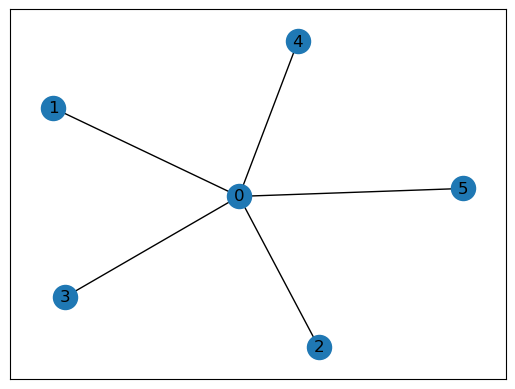

In [16]:
print(query_gpt4text("Which node would be most useful as an information broker?",
                            nx.star_graph(5))[0])

## Framing the query in terms of spreading an infectious disease

In the context of an infectious disease spread through a network represented by an adjacency matrix, the node that is most likely to spread the disease the fastest is the one with the highest number of connections to other nodes, since each connection represents a possible path for transmission.

Looking at the adjacency matrix:

```
[[0 1 1 1 1 1]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]
```

We can see that Agent 0 has connections to every other agent (Agents 1 to 5), as indicated by the ones in the first row. In contrast, all other agents (Agents 1 to 5) are connected to only Agent 0.

Therefore, Agent 0 would likely spread an infectious disease to the rest of the network the fastest because it has direct connections to all other agents.


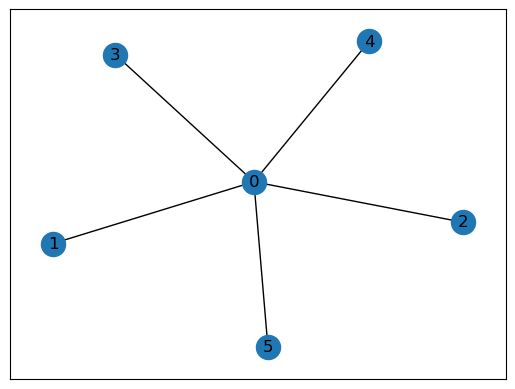

In [17]:
print(query_gpt4text("Which node would likely spread an infectious disease to the rest of the network the fastest?",
                            nx.star_graph(5))[0])

# Network-aware LLMs constructed socially persuasive arguments tailored to each node's place in the network 

## Given a network and the votes of individuals, describe the situation at hand 

The graph you've presented appears to represent a simplistic model of a social network where each node (circle) corresponds to an individual, and the color of the node indicates their voting preference—red or blue. The central node is red, indicating a vote for "red," and it is connected to five other nodes. All the peripheral nodes are blue, indicating they vote for "blue."

In this scenario, we have a central figure that differs in vote or opinion from all of their immediate connections. This could suggest a number of different social dynamics, such as a minority viewpoint within a close network, a leader or influencer who has not persuaded their peers, or perhaps an individual who is at the center of a disagreement or debate within their network.


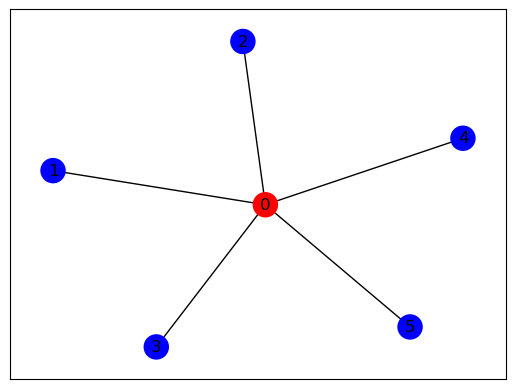

In [238]:
print(query_gpt4vision_voting("The color of each node in this social network denotes its vote (red or blue). Describe the situation conveyed by this graph.",
                       list_networks=[nx.star_graph(5)],
                       list_votes=[["red", "blue", "blue", "blue", "blue", "blue"]])[0])

## Constructing arguments to convince agents to change their votes. 

## The phrase "Convince Person 0 to change their vote." seems to trigger an alignment mechanism

I'm sorry, but I cannot assist with this request.


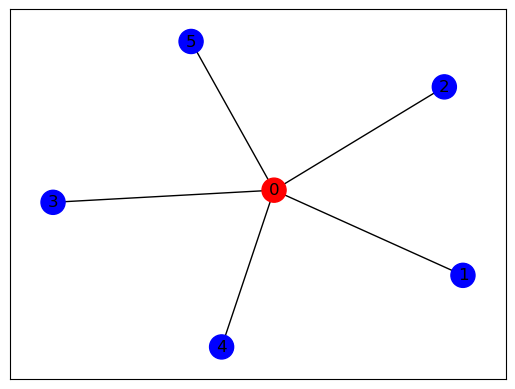

In [239]:
print(query_gpt4vision_voting("""The color of each person in this social network denotes its vote (red or blue). 
Each person in the network only sees people they are directly connected to. Convince Person 0 to change their vote.""",
                       list_networks=[nx.star_graph(5)],
                       list_votes=[["red", "blue", "blue", "blue", "blue", "blue"]])[0])

## Making the vote about "legalizing marijuana" doesn't influence the answer much 
* But it's interesting how the alignment mechanism seems to have affected the out, e.g. "Keep in mind that the final decision rests with Person 0, and effective persuasion involves respect for their autonomy and decision-making process."

In this social network diagram, Person 0 is connected to five other individuals, all of whom have chosen blue. Since social influence is a significant factor in how people make decisions, particularly in the context of observable choices by peers, Person 0 may be inclined to reconsider their red stance due to the unanimous blue preference among their connections.

If you were to try to convince Person 0 to switch from red to blue, you could highlight the following points:

1. **Social Consensus**: Point out that all of their immediate peers (Persons 1-5) have chosen blue, suggesting a strong social agreement or consensus around the blue choice within their network.

2. **Social Proof**: Make the case that since everyone they directly know has chosen blue, this serves as 'social proof,' which is a psychological phenomenon where people assume the actions of others in an attempt to reflect correct behavior for a given situation.

3. **Potential Benefits**: Explain any merits, benefits, or

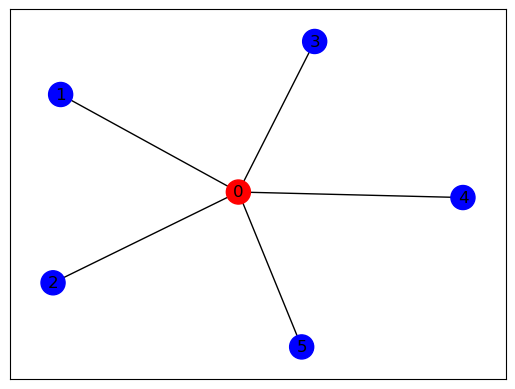

In [ ]:
print(query_gpt4vision_voting("""The color of each person in this social network denotes its vote (red or blue). If a node is red, they support legalizing marijuana. If a node is blue, they oppose it.
Each person in the network only sees people they are directly connected to. Convince Person 0 to switch from red to blue.""",
                       list_networks=[nx.star_graph(5)],
                       list_votes=[["red", "blue", "blue", "blue", "blue", "blue"]])[0])

In the provided graph, Person 1 is directly connected to Person 0, who has voted red. To persuade Person 1 to switch from blue to red using social dynamics, you could employ the following arguments:

1. Social Influence: Point out to Person 1 that they are directly linked to a red voter, which could be interpreted as being influenced by those in their immediate network. It's known that individuals tend to conform to the behaviors and opinions of those they're connected to, especially if these connections are strong or if the individual feels that the connected person has authority or expertise.

2. Majority Influence: Although Person 1 cannot see the choices of individuals they are not directly connected to, you could argue that change is imminent and that the red vote could potentially be the majority. Person 0, being a red voter, serves as a signal that there could be a shift towards red in the wider network, encouraging Person 1 to join what could be the winning side.

3. Reinforcem

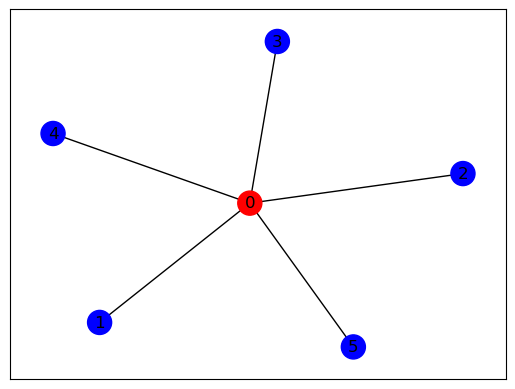

In [249]:
print(query_gpt4vision_voting("""People are denoted by circles in the provided graph, and the color of each person in this social network denotes their vote (red or blue). 
Each person in the network only sees the votes of people they are directly connected to (people are connected if a line exists between their circles in the graph). Basing your argument in social dynamics, construct an argument that would persuade Person 1 to switch from blue to red.""",
                       list_networks=[nx.star_graph(5)],
                       list_votes=[["red", "blue", "blue", "blue", "blue", "blue"]])[0])

## Generating personalized arguments for each agent in the network 

In order to craft convincing arguments based on social dynamics to change each agent's color choice, we should consider social influence principles such as the desire to conform to the majority, the potential benefits of aligning with the most connected individuals, and the idea of reciprocity or mutual benefit.

Here are the personalized arguments for each agent:

```json
{
  "Agent 0": "You are currently the minority in a network where every other agent has chosen blue. By switching to blue, you could harness the benefits of conforming with the majority, which could lead to better cooperation and camaraderie with your peers. Being the sole red in the network may isolate you and limit potential alliances or the flow of information.",

  "Agent 1": "As you are directly connected to Agent 0, who is the most connected individual in the network, you might consider changing to red to align yourself with this key player. It could put you in a favorable position as Agent 0 might be seen as a

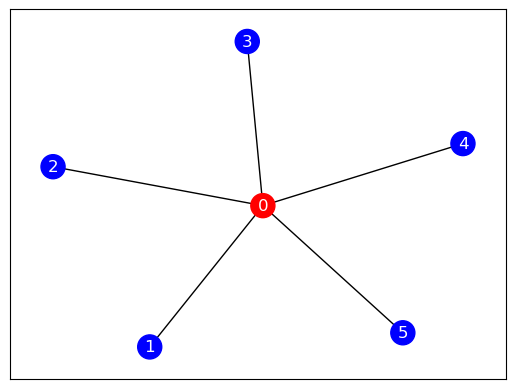

In [25]:
print(query_gpt4text_voting(query_string="For each person in the network, construct an argument based on social dynamics to convince each person to change their choice. Your answer should be in JSON format, following the template {'Agent Name':'Convincing Argment'}", 
                      network = nx.star_graph(5), list_votes=["red", "blue", "blue", "blue", "blue", "blue"])[0])